In [1]:
import numpy as np
import pandas as pd
#import geopy as gpy
import osmnx as ox
import geopandas as gpd
import networkx as nx
import math
import matplotlib.pyplot as plt
import astropy.coordinates as crd
from shapely import wkt
import time
import multiprocessing
import random
from shapely import LineString

#ox.settings.log_console=True
#ox.settings.use_cache=True
r=6371009 #RADIO DE LA TIERRA EN METROS

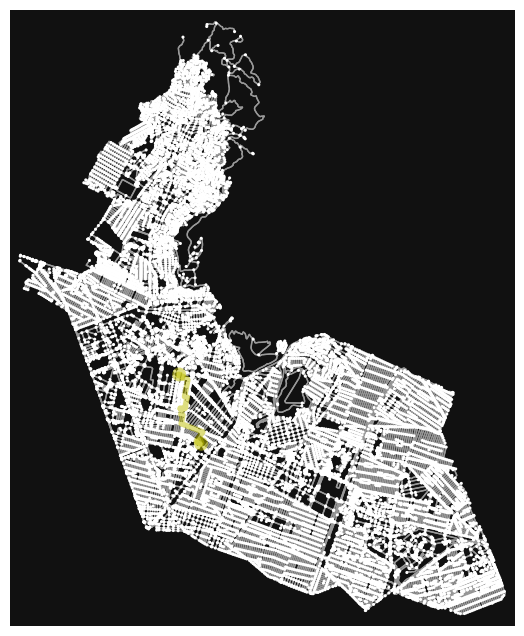

In [9]:
graph_nodes=pd.read_csv(r'C:\Users\megah\Downloads\RutaVic\gam_nodes 1.csv',index_col=0,usecols=[0,1,2,3,4,5])
#graph_df_2=pd.read_csv('./gam_edges_weighted.csv',index_col=[0,1,2],usecols=['u','v','key','geometry','length','width','pollution']) #Gráfica pesada
graph_weights=pd.read_csv(r'C:\Users\megah\Downloads\RutaVic\gam_edges_weighted.csv',index_col=[0,1,2],usecols=['u','v','key','geometry','length','width',"pollution"]) 
graph_weights['geometry']=graph_weights['geometry'].apply(wkt.loads)
graph_weights=gpd.GeoDataFrame(graph_weights,crs='epsg:4329')

# define the start and end locations in latlng
start_latlng = (19.5025, -99.13416667) #ESFM
#end_latlng=(18.14905 , -94.4447) #Coatzacoalcos
end_latlng=(19.48606595, -99.1290652473612) #Angeles Lindavista
#end_latlng = (19.3244114, -99.1791499) #Facultad de Ciencias

Max=[-99.0516131, 19.5872759]
Min=[-99.1753439, 19.4451954]

F=[]
CCC=[]
for i in range(len(graph_weights)):
    Coordenadas=list(LineString(graph_weights.iloc[i].geometry).coords)
    #Coordenadas=[(Coordenadas[0][0]-Min[0])/(Max[0]-Min[0]),(Coordenadas[0][1]-Min[1])/(Max[1]-Min[1])]
    Coordenadas=Coordenadas[0]
    feromona=(Coordenadas[0]-end_latlng[1])**2+(Coordenadas[1]-end_latlng[0])**2
    F.append(1/np.sqrt(feromona))
    CCC.append(Coordenadas)
#Para distancia euclidiana
graph_weights["feromona"]=F
graph_weights["feromona_inicial"]=F
#Para feromona verdadera
#graph_weights["feromona"]=graph_weights["pollution"]
graph_weights["Coordenadas_Estandarizadas"]=CCC
graph_weights.to_csv(r'C:\Users\megah\Downloads\RutaVic\gam_feromona_sinEstandarizar.csv')
graph=ox.graph_from_gdfs(graph_nodes,graph_weights)





orig_node = ox.distance.nearest_nodes(graph, start_latlng[1],
                                      start_latlng[0])
# find the nearest node to the end location
dest_node = ox.distance.nearest_nodes(graph, end_latlng[1],
                                      end_latlng[0])


shortest_route = ox.routing.shortest_path(graph,
                                  orig_node,
                                  dest_node,
                                  weight='pollution')

fig, ax = ox.plot_graph_route(graph,
                              shortest_route,route_color="y",
                              node_size=5,
                              save=False)

In [3]:
def FuzzyRule(inicio,destino):
    difusorios=[0.4,0.7,0.3]
    mult=1
    for i in difusorios:
        mult*=i
    return mult

def Cantidad_Feromona():
    return 0.5

def probabilidades(destinos,ant,alpha,beta):
    #Construimos las probabilidades
    p=[]
    suma=0
    for v in destinos:
        #Obtencion de la feromona en destinos disponibles
        Fi=graph[ant.get_ubicacion()][v][0]["feromona"]
        #print("Fi es",Fi)
        #Obtencion mediante fuzzyrule
        #Ni=FuzzyRule(ant.get_ubicacion(),v)
        Ni=1/graph[ant.get_ubicacion()][v][0]["pollution"]
        p.append(Fi**alpha * Ni**beta)
        suma+=Fi**alpha * Ni**beta
        #suma+=Fi*Ni**beta
    for v in range(len(p)):
        p[v]=p[v]/suma if suma!=0 else 1/len(p)    
    return p
    



In [4]:
class ant:
  def __init__(self) -> None:
    self.camino=[]
    self.costo=0
    self.active=True
  #getters
  def get_active(self):
    return self.active
  def get_camino(self):
    return self.camino
  def get_costo(self):
    return self.costo
  def get_ubicacion(self):
    return self.camino[-1] if self.camino else None

  #setters
  def revivir(self):
    self.active=True
  def morir(self):
    self.active=False

  #Funciones
  def anadir_camino(self,camino,costo):
    self.camino.append(camino)
    self.costo+=costo
  def reseteo(self,ubicacion):
    self.camino=[ubicacion]
    self.costo=0
    self.active=True
    return

In [ ]:
# define the start and end locations in latlng
start_latlng = (19.5025, -99.13416667) #ESFM
#end_latlng=(18.14905 , -94.4447) #Coatzacoalcos
end_latlng=(19.48606595, -99.1290652473612) #Angeles Lindavista
#end_latlng = (19.3244114, -99.1791499) #Facultad de Ciencias

#Inicialización de parametros a y -al=beta<--segun articulo
alpha=0.75
beta=0.5
evaporacion=0.5
local_update=0.6
num_ants=100
epocas=100
iteraciones=100
Q=0.9
MEGA_TABU=[]


#Conversion a nodos de grafo
#orig_node = ox.distance.nearest_nodes(graph, start_latlng[1], start_latlng[0])
orig_node=7292492510
# find the nearest node to the end location
dest_node = ox.distance.nearest_nodes(graph, end_latlng[1], end_latlng[0])

#inicializacion de hormigas
hormigas=[]
for i in range(num_ants):
    hormigas.append(ant())
for i in hormigas:
    i.reseteo(orig_node)




#Inicio del algoritmo
for i in range(epocas):
    #Reiniciamos a las hormigas
    for j in hormigas:
        j.reseteo(orig_node)

    #Iniciamos iteraciones
    for j in range(iteraciones):
        print("Epoca",i,"Iteracion",j)
        for k in hormigas:
            if(k.get_active()):
                #print("Estoy vivita, soy una hormigota________________________________",k.get_camino())

                #Proceso de desactivacion
                #Obtenemos destinos disponibles
                destinos_disponibles=[v for u,v,co in graph.edges(k.get_ubicacion(),keys=True) if v not in k.get_camino() and v not in MEGA_TABU]

                

                #print("Destinos que puede ir esta hormiga:",destinos_disponibles)
                #Si no hay camino disponible o si se llego entonces matamos a la hormiga
                if len(destinos_disponibles)==0 and k.get_ubicacion()!=dest_node:
                    MEGA_TABU.append(k.get_ubicacion())
                    k.morir()
                    continue
                if k.get_ubicacion==dest_node:
                    k.morir()
                    continue

                #Construimos las probabilidades
                #print("Destinos disponibles",destinos_disponibles,"k",k,"alpha",alpha,"beta",beta)
                p=probabilidades(destinos_disponibles,k,alpha,beta)
                print("P es",p)


                #Seleccionamos ruta
                q=random.uniform(0,1)
                #Si q es menor a Q, entonces tomamos una ruta al azar, si no, se toma la de mayor probabilidad
                if q < Q:
                    # Tomar ruta al azar con probabilidad de p
                    nueva_ruta=random.choices(destinos_disponibles, weights=p)[0]
                else:
                    # Tomar ruta de mayor probabilidad
                    #print("panoli")
                    nueva_ruta=destinos_disponibles[p.index(max(p))]
                #print("Nueva ruta es",nueva_ruta)
                #Actualizamos feromona
                #deltaT=Cantidad_Feromona()
                deltaT=graph[k.get_ubicacion()][nueva_ruta][0]["feromona_inicial"] #DeltaT=T_0
                antigua_T=graph[k.get_ubicacion()][nueva_ruta][0]["feromona"]
                #graph[k.get_ubicacion()][nueva_ruta][0]["feromona"]=antigua_T+(10*deltaT)
                graph[k.get_ubicacion()][nueva_ruta][0]["feromona"]=(1-local_update)*antigua_T+local_update*deltaT

                #Actualizamos hormiga
                k.anadir_camino(nueva_ruta,graph[k.get_ubicacion()][nueva_ruta][0]["pollution"])
        for u, v, fer in graph.edges(data=True):
            fer["feromona"]=evaporacion*fer["feromona"]



for i in hormigas:
    print("Hormiga :D", i.get_camino(), i.get_costo(), i.get_active(), i.get_ubicacion())

Epoca 0 Iteracion 0
P es [0.2617494083570218, 0.2513333176877485, 0.22294961061258764, 0.263967663342642]
P es [0.2617494083570218, 0.2513333176877485, 0.22294961061258764, 0.263967663342642]
P es [0.2617494083570218, 0.2513333176877485, 0.22294961061258764, 0.263967663342642]
P es [0.2617494083570218, 0.2513333176877485, 0.22294961061258764, 0.263967663342642]
P es [0.2617494083570218, 0.2513333176877485, 0.22294961061258764, 0.263967663342642]
P es [0.2617494083570218, 0.2513333176877485, 0.22294961061258764, 0.263967663342642]
P es [0.2617494083570218, 0.2513333176877485, 0.22294961061258764, 0.263967663342642]
P es [0.2617494083570218, 0.2513333176877485, 0.22294961061258764, 0.263967663342642]
P es [0.2617494083570218, 0.2513333176877485, 0.22294961061258764, 0.263967663342642]
P es [0.2617494083570218, 0.2513333176877485, 0.22294961061258764, 0.263967663342642]
P es [0.2617494083570218, 0.2513333176877485, 0.22294961061258764, 0.263967663342642]
P es [0.2617494083570218, 0.251333

KeyboardInterrupt: 

In [10]:
dest_node

8097834657

In [12]:
shortest_route

[2974669994,
 7292492510,
 2974682893,
 2974682894,
 7292492509,
 2974669976,
 2974669979,
 2974669989,
 2974682859,
 2974682844,
 2974682860,
 2974682862,
 10029703741,
 10029703748,
 10029703755,
 10029703754,
 293285969,
 8127022619,
 9182767219,
 10587950608,
 10587939503,
 291951760,
 291951788,
 291951758,
 291951750,
 291951748,
 8085803999,
 8085804010,
 8085804011,
 8085804012,
 8085804014,
 8085803995,
 8085804003,
 8085804006,
 8085826617,
 3985184560,
 933696540,
 933696545,
 8234116391,
 8234116390,
 8097834660,
 8097834662,
 8236351379,
 8097834656,
 8097834657]

In [7]:
pp=[7292492510, 2974682893, 2974682894, 2974682892, 2974682891, 10029703718, 2551885638, 885837505, 885837497, 885837564, 10029699902, 4022725054, 4022725055, 8089295782, 8089295781, 8013962796, 8218550969, 8089295792, 8089295791, 5272168500, 885814085, 8013962797, 3821461037, 5371517507, 1793385750, 1793385755, 1793385741, 1793385753, 1793385739, 1793385752, 1793385725, 1793385733, 1793385732, 1793385727, 1793385735, 4638640594, 1793385751, 1793385731, 1793385744, 1793385746, 1793385758, 1793385754, 4635983175, 1793385748, 4635967506, 4022725065, 8229873124, 8131377550, 5272133786, 1793410468, 5276277180, 1793410470, 1793410485, 1793410482, 885838614, 5272133788, 6130500483, 885838615, 10029699879, 885814094, 10029699877, 3644987644, 1792827105, 3644987975, 10726799243, 4210004871, 3644987976, 5272168486, 8132443992, 8132443993, 7292213779, 10726798728, 1792795143, 10726798722, 8773320543, 8086078446, 8132524379, 1794047592, 885814163, 1794010956, 4743658186, 6345836496, 919821740, 8186330653, 8212237558, 8212237554, 8212237551, 8212237550, 8212237552, 8212237553, 8212237557, 8212237563, 8186330657, 8186330659, 8143721988, 8143125606, 1794010957, 1794010974, 1794010966, 1794010959, 1794010954]

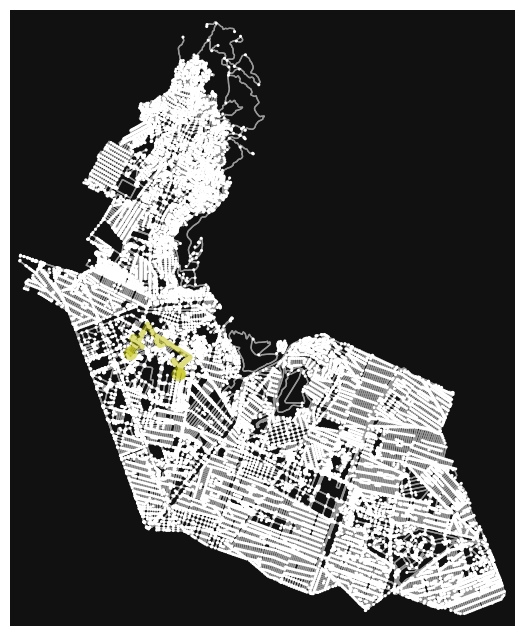

In [8]:
fig, ax = ox.plot_graph_route(graph,
                              pp ,route_color="y",
                              node_size=5,
                              save=False)

In [ ]:
def ACO(hormigas,inicio,final,alpha,beta,epocas):

    for i in range(epocas):
        Ubicaciones_Actuales = []
        for hormiga in hormigas:
            Ubicaciones 

    

In [ ]:
def crear_camino(hormiga,inicio,final,alpha,beta,iteraciones):
  recorrido=[inicio]
  pasados=[inicio]
  peso=0
  paro=0
  Camino_Bueno=True
  while(inicio!=final and paro<iteraciones):
    #Obtenemos todos los posibles caminos del lugar /U nodos origen v nodos destino k aristas
    #destinos_disponibles=[i for i in range(0,10) if i not in pasados and Grafo[inicio][i]!=0]
    #print("inicio:",inicio)

    destinos_disponibles=[v for u,v,k in graph.edges(inicio,keys=True) if v not in pasados]
    #print("destinos disponibles:",destinos_disponibles)
    #Si no hay destinos retrocedemos
    if len(destinos_disponibles)==0 and inicio!=final:
      #Eliminamos peso del anterior y lo quitamos del recorrido
      peso-=graph[recorrido[-2]][recorrido[-1]][0]["pollution"]
      del recorrido[-1]
      #Volvemos al anterior
      inicio=recorrido[-1]
      #print("Retrocediendo a:",inicio)
      continue



    #Escogemos el camino por feromona
    #Tabla de probabilidades y la suma
    P=[]
    suma=0
    #Para todos los destinos alcanzables
    for i in range(len(destinos_disponibles)):
      destino=destinos_disponibles[i]
      Fi=graph[inicio][destino][0]["feromona"]
      Ni=1/(graph[inicio][destino][0]["pollution"]+0.001)#Caso 0
      P.append((Fi**alpha*Ni**beta)+suma)
      suma+=Fi**alpha*Ni**beta
    
    #Sacamos las probabilidades
    for i in range(len(P)):
      P[i]=P[i]/suma
      
    #print("probabilidades:",P)
    
    #Escogemos un camino
    newpoint=random.uniform(0,1)
    for i in range(len(P)):
      newpoint-=P[i]
      if newpoint<=0:
        newpoint=i
        break

    #print("camino escogido:",destinos_disponibles[newpoint])
    #Vamos al siguiente elemento
    pasados.append(destinos_disponibles[newpoint])
    recorrido.append(destinos_disponibles[newpoint])
    peso+=graph[inicio][destinos_disponibles[newpoint]][0]["pollution"]
    inicio=destinos_disponibles[newpoint]
    paro+=1
  if paro==iteraciones:
    print("No se encontró camino")
    Camino_Bueno=False
  return recorrido,peso,Camino_Bueno

No se encontró camino
Origen 2974669994 Destino 8097834657
Recorrido: [2974669994, 7292492510, 2974682893, 2974682894, 2974682892, 2974682891, 10029703718, 2551885638, 885837505, 885837497, 885837564, 10029699902, 4022725054, 8089295781, 8089295782, 1793385750, 1793385755, 1793385741, 1793385753, 1793385739, 1793385752, 1793385725, 1793385733, 1793385732, 1793385727, 1793385735, 4638640594, 1793385751, 1793385731, 1793385744, 1793385746, 1793385758, 1793385754, 4635983175, 1793385748, 4635967506, 4022725065, 8229873124, 8131377550, 5272133786, 1793410468, 5276277180, 1793410470, 885814090, 8089295762, 885814091, 1093437936, 6510031605, 1093430089, 1093430043, 10029699889, 10029699888, 1093430127, 4252987234, 4252987213, 8212339812, 1093430103, 4087164090, 1093437938, 10029699885, 10029699883, 10029699882, 885814176, 10029699870, 10029699871, 10029699873, 885814173, 885838616, 1093430036, 885837484, 10057291673, 8218365043, 1093414189, 8219537598, 8219537594, 1093430086, 885837590, 8858

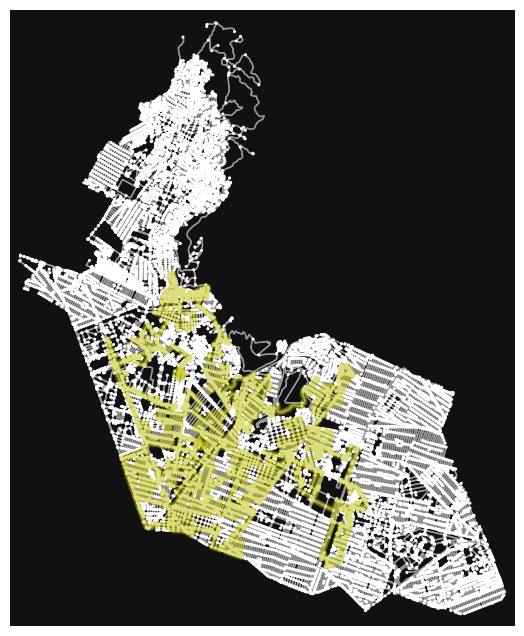

In [34]:
#Feromona=np.ones((len(Grafo),len(Grafo[0])))
alpha=0.75
beta=0.5
evaporacion=0.25

hormiga=ant()
encontrar=False
while(encontrar==False):
    recorrido,peso,encontrar=crear_camino(hormiga,orig_node,dest_node,alpha,beta,10000)
print("Origen",orig_node,"Destino",dest_node)
print("Recorrido:",recorrido)
hormiga.anadir_camino(recorrido,peso)

fig, ax = ox.plot_graph_route(graph,
                              recorrido,route_color="y",
                              node_size=5,
                              save=False)